In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import os
os.chdir("/Users/bytedance/MLTrader-deploy/")
import sys
sys.path.insert(0, ".")
import research.orderbook_strategies.utils.helper as helper
import research.orderbook_strategies.utils.stats as stats
import research.orderbook_strategies.utils.factor_analysis as factor_analysis
import research.orderbook_strategies.utils.factors as factors
import dask
from dask import compute, delayed
from dask.diagnostics import ProgressBar
from imp import reload   
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [7]:
import warnings
 
warnings.filterwarnings('ignore')

product_list = ["OPUSDT","BTCUSDT", "ETHUSDT", "APTUSDT", "1000PEPEUSDT"]

In [108]:
# date_str = "2023-08-12" # pepe大涨
# date_str = "2023-08-17" # pepe大跌
date_str = "2023-07-13" # eth大涨
agg_trades_by_product = {}
for product in product_list:
    if product == "1000PEPEUSDT":
        agg_trade_p = Path("/Volumes/AdamDrive/binance_data/data/spot/daily/aggTrades") / "PEPEUSDT" / f"PEPEUSDT-aggTrades-{date_str}.csv"
    else:
        # agg_trade_p = Path("/Volumes/AdamDrive/binance_data/data/futures/um/daily/aggTrades") / product / f"{product}-aggTrades-{date_str}.csv"
        agg_trade_p = Path("/Volumes/AdamDrive/binance_data/data/spot/daily/aggTrades") / product / f"{product}-aggTrades-{date_str}.csv"
    # trade_p = Path("/Volumes/AdamDrive/binance_data/data/futures/um/daily/trades")  / product / f"{product}-trades-{date_str}.csv"
    # df = pd.read_csv(agg_trade_p)
    # df = pd.read_csv(agg_trade_p, header=None, names=["agg_trade_id",
    #                                                   "price",
    #                                                   "quantity",
    #                                                   "first_trade_id",
    #                                                   "last_trade_id",
    #                                                   "transact_time",
    #                                                   "is_buyer_maker", "nan"])
    # df["transact_time"] = pd.to_datetime(df["transact_time"], unit='ms')
    
    agg_trades_by_product[product] = helper.get_trades_data(product, date_str)

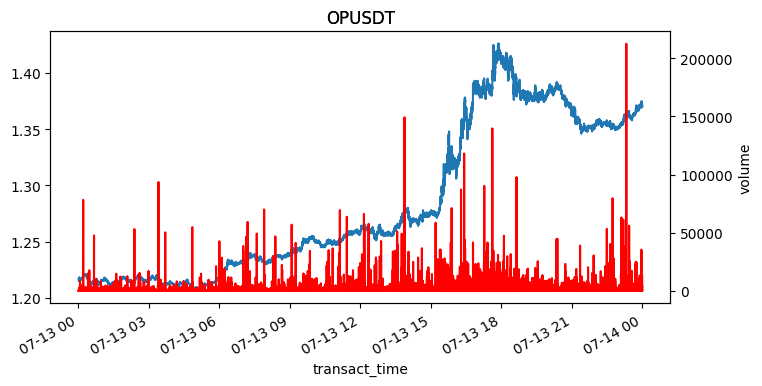

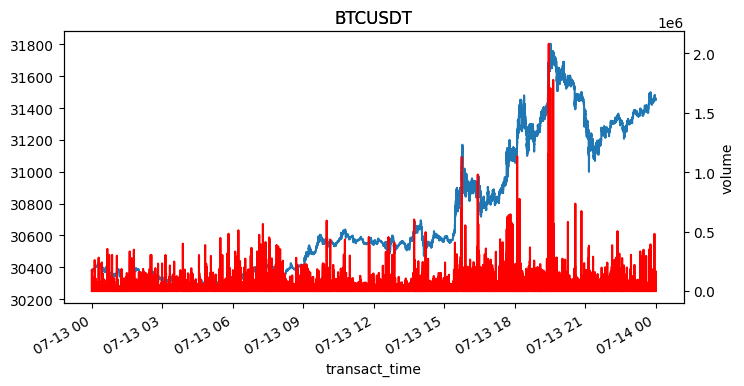

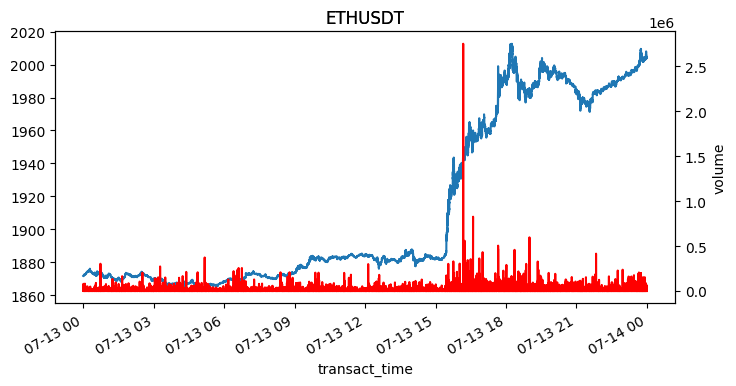

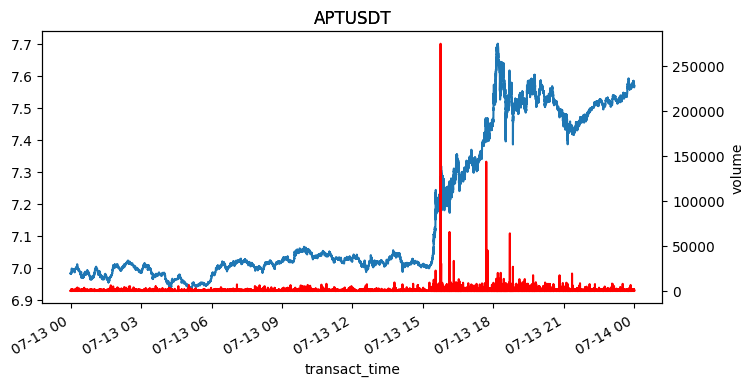

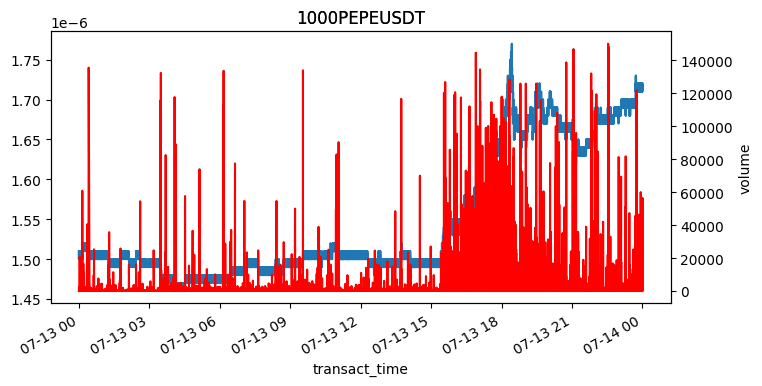

In [87]:
# 现货
for product in product_list:
    price_df = agg_trades_by_product[product]
    price_df = price_df.set_index("transact_time")
    price_df["quote_qty"] = price_df["quantity"] * price_df["price"]
    price_df["quote_qty_buy"] = np.where(price_df["is_buyer_maker"], price_df["quote_qty"], 0)
    price_df["quote_qty_sell"] = np.where(price_df["is_buyer_maker"], 0, price_df["quote_qty"])
    price_df["quote_qty_buy_ma100"] = price_df["quote_qty_buy"].rolling(1000).mean()
    price_df["quote_qty_sell_ma100"] = price_df["quote_qty_sell"].rolling(1000).mean()
    price_df["quote_qty_ratio"] = price_df["quote_qty_buy_ma100"] / price_df["quote_qty_sell_ma100"]
    price_df["price"] = price_df["price"].astype(float)
    ax = price_df["price"].plot(figsize=(8, 4), title=product)
    ax2 = ax.twinx()
    ax2.set_ylabel("volume")
    # price_df["quote_qty_ratio"].plot(figsize=(8, 4), title=product, ax=ax2, color="green")
    price_df["quote_qty"].plot(figsize=(8, 4), title=product, ax=ax2, color="red")
    plt.show()

In [88]:
agg_trades_by_product = {}
for product in product_list:
    agg_trade_p = Path("/Volumes/AdamDrive/binance_data/data/futures/um/daily/aggTrades") / product / f"{product}-aggTrades-{date_str}.csv"
    # trade_p = Path("/Volumes/AdamDrive/binance_data/data/futures/um/daily/trades")  / product / f"{product}-trades-{date_str}.csv"
    df = pd.read_csv(agg_trade_p)
    df["transact_time"] = pd.to_datetime(df["transact_time"], unit='ms')
    agg_trades_by_product[product] = df

In [89]:
for product in product_list:
    price_df = agg_trades_by_product[product]
    print("product:", product)
    seconds_per_day = 24 * 60 * 60
    print("price: {}".format(price_df["price"].shape[0] / seconds_per_day))

product: OPUSDT
price: 3.6474189814814815
product: BTCUSDT
price: 20.092476851851853
product: ETHUSDT
price: 12.396643518518518
product: APTUSDT
price: 1.5511458333333332
product: 1000PEPEUSDT
price: 6.303530092592593


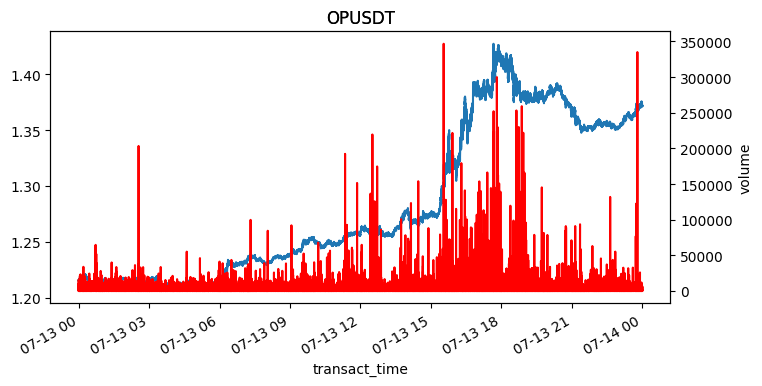

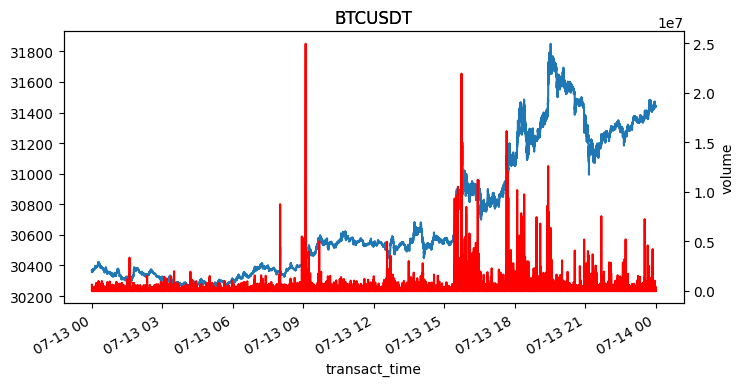

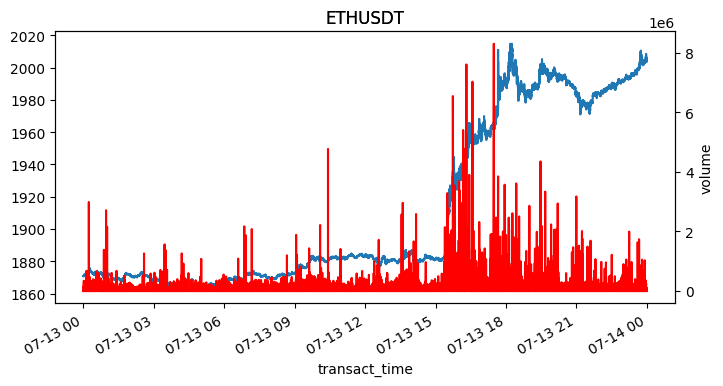

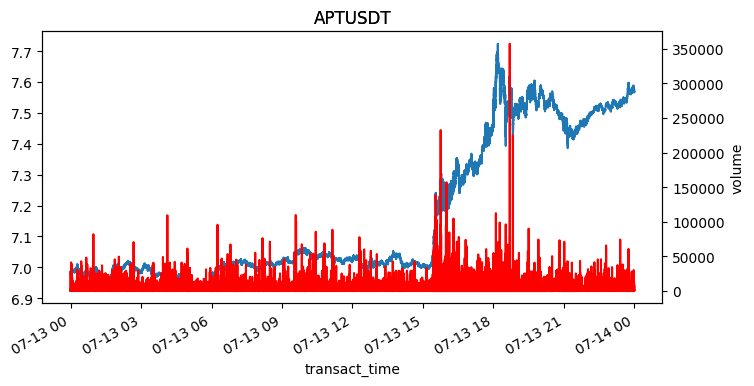

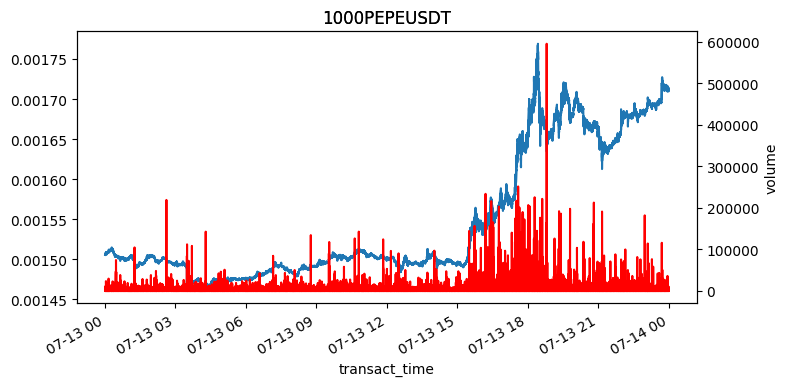

In [90]:
# 期货
for product in product_list:
    price_df = agg_trades_by_product[product]
    price_df = price_df.set_index("transact_time")
    price_df["quote_qty"] = price_df["quantity"] * price_df["price"]
    price_df["quote_qty_buy"] = np.where(price_df["is_buyer_maker"], price_df["quote_qty"], 0)
    price_df["quote_qty_sell"] = np.where(price_df["is_buyer_maker"], 0, price_df["quote_qty"])
    price_df["quote_qty_buy_ma100"] = price_df["quote_qty_buy"].rolling(1000).mean()
    price_df["quote_qty_sell_ma100"] = price_df["quote_qty_sell"].rolling(1000).mean()
    price_df["quote_qty_ratio"] = price_df["quote_qty_buy_ma100"] / price_df["quote_qty_sell_ma100"]
    price_df["price"] = price_df["price"].astype(float)
    ax = price_df["price"].plot(figsize=(8, 4), title=product)
    ax2 = ax.twinx()
    ax2.set_ylabel("volume")
    # price_df["quote_qty_ratio"].plot(figsize=(8, 4), title=product, ax=ax2, color="green")
    price_df["quote_qty"].plot(figsize=(8, 4), title=product, ax=ax2, color="red")
    plt.show()

In [74]:
metrics_by_product = {}
for product in product_list:
    metrics_by_product[product] = helper.get_metrics_data(product, date_str)
    
merged_by_product = {}
for product in product_list:
    price_df = agg_trades_by_product[product]
    metric_df = metrics_by_product[product]
    price_df = price_df.set_index("transact_time")
    metric_df["sum_open_interest_value_log_diff"] = np.log(metric_df["sum_open_interest_value"]).diff(1)
    # price_df["quote_qty_ratio"].plot(figsize=(8, 4), title=product, ax=ax2, color="green")
    metric_df["more_position.12"] = (metric_df["sum_open_interest_value_log_diff"] > 0).rolling(12).mean()
    merged = pd.merge_asof(price_df, metric_df[['sum_open_interest', 'sum_open_interest_value', 'count_long_short_ratio', 'sum_taker_long_short_vol_ratio', 'sum_open_interest_value_log_diff', 'more_position.12']], left_index=True, right_index=True, direction='backward')
    merged_by_product[product] = merged

<AxesSubplot:title={'center':'OPUSDT'}, xlabel='transact_time', ylabel='volume'>

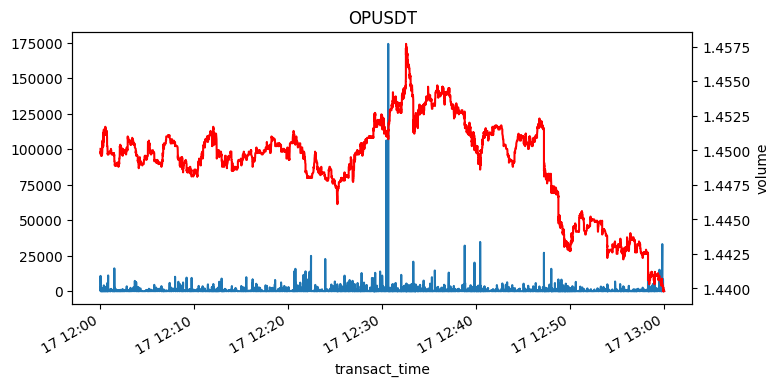

In [59]:
price_df = agg_trades_by_product["OPUSDT"]
price_df = price_df.set_index("transact_time")
buy = pd.Series(np.where(price_df["is_buyer_maker"], price_df["quantity"], 0), index=price_df.index)
ax = buy.loc["2023-08-17 12"].plot()
ax2 = ax.twinx()
ax2.set_ylabel("volume")
# price_df["quote_qty_ratio"].plot(figsize=(8, 4), title=product, ax=ax2, color="green")
price_df.loc["2023-08-17 12"]["price"].plot(figsize=(8, 4), title="OPUSDT", ax=ax2, color="red")

<AxesSubplot:title={'center':'APTUSDT'}, xlabel='transact_time', ylabel='volume'>

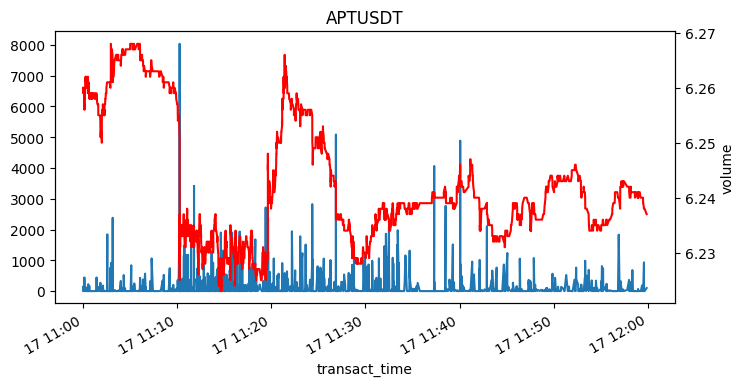

In [61]:
price_df = agg_trades_by_product["APTUSDT"]
price_df = price_df.set_index("transact_time")
buy = pd.Series(np.where(price_df["is_buyer_maker"], price_df["quantity"], 0), index=price_df.index)
ax = buy.loc["2023-08-17 11"].plot()
ax2 = ax.twinx()
ax2.set_ylabel("volume")
# price_df["quote_qty_ratio"].plot(figsize=(8, 4), title=product, ax=ax2, color="green")
price_df.loc["2023-08-17 11"]["price"].plot(figsize=(8, 4), title="APTUSDT", ax=ax2, color="red")

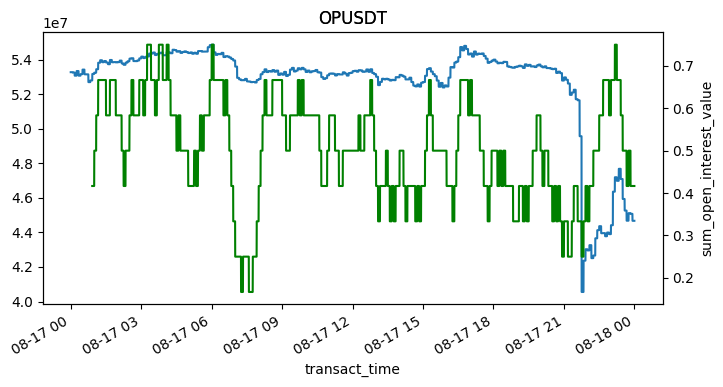

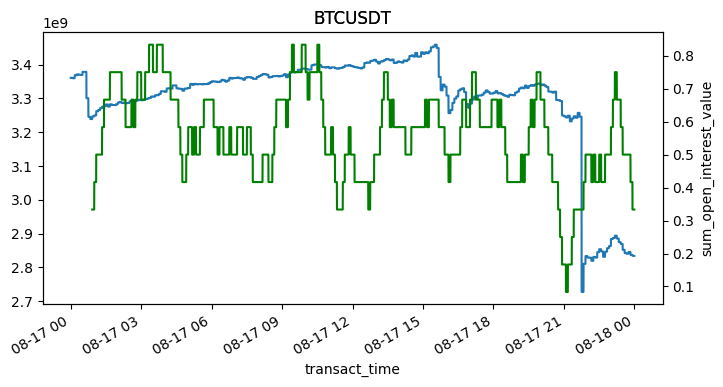

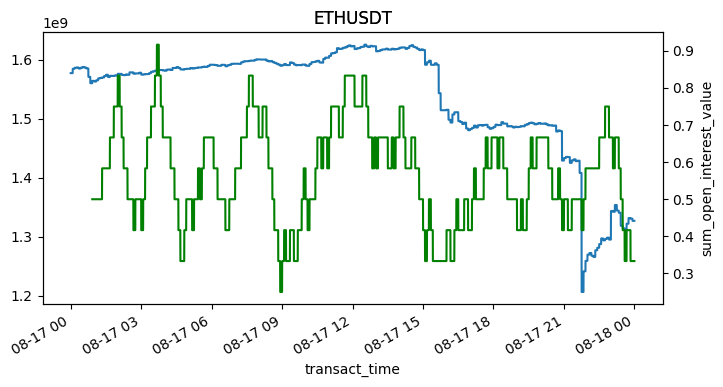

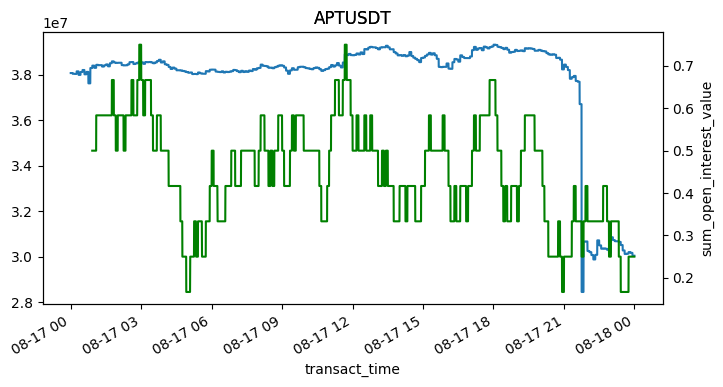

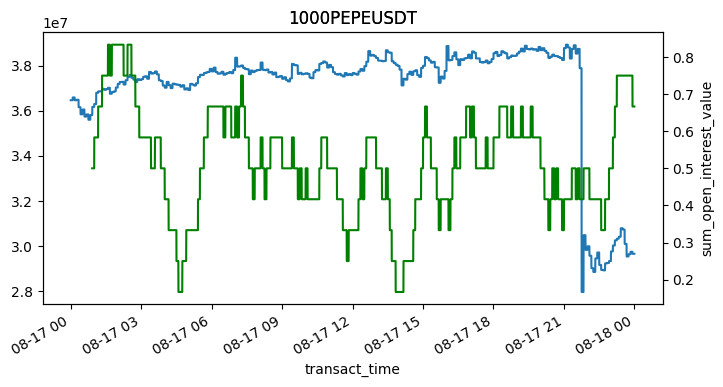

In [75]:
for product in product_list:
    merged = merged_by_product[product]
    ax = merged["sum_open_interest_value"].plot(figsize=(8, 4), title=product)
    ax2 = ax.twinx()
    ax2.set_ylabel("sum_open_interest_value")
    merged["more_position.12"].plot(figsize=(8, 4), title=product, ax=ax2, color="green")
    # (merged["sum_open_interest_value_log_diff"] > 0).rolling(60000).mean().plot(figsize=(8, 4), title=product, ax=ax2, color="red")
    plt.show()

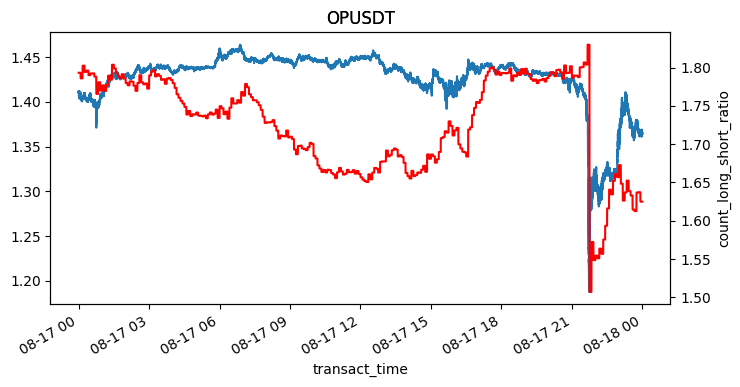

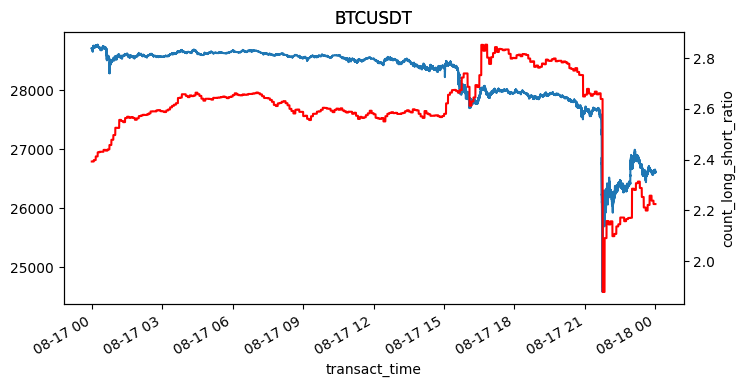

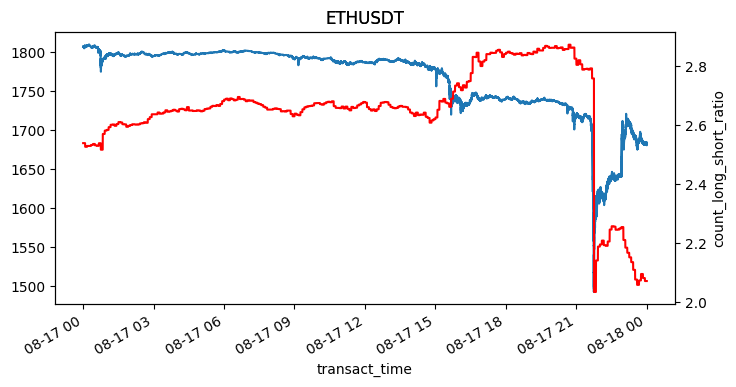

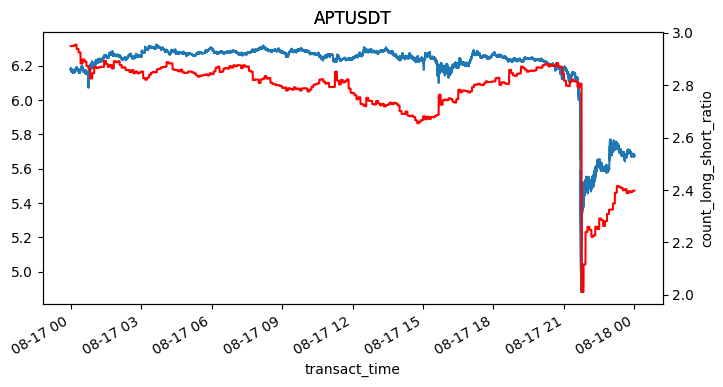

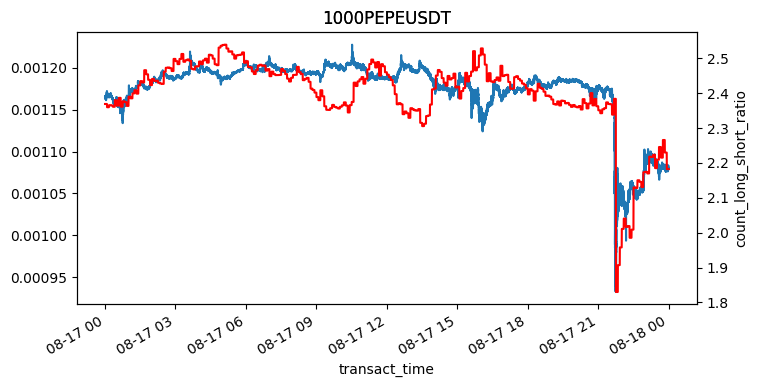

In [42]:
for product in product_list:
    merged = merged_by_product[product]
    ax = merged["price"].plot(figsize=(8, 4), title=product)
    ax2 = ax.twinx()
    ax2.set_ylabel("count_long_short_ratio")
    # price_df["quote_qty_ratio"].plot(figsize=(8, 4), title=product, ax=ax2, color="green")
    merged["count_long_short_ratio"].plot(figsize=(8, 4), title=product, ax=ax2, color="red")
    plt.show()

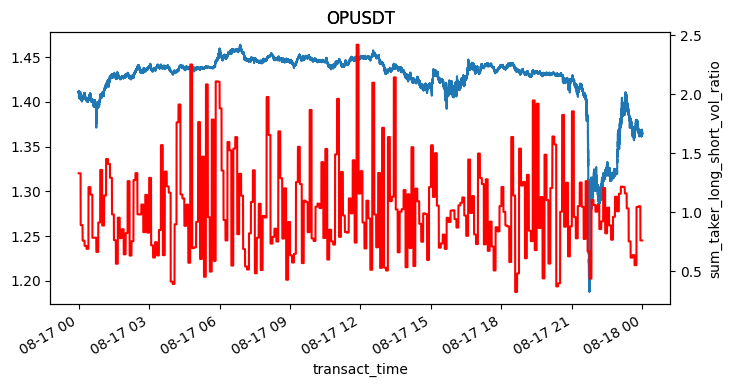

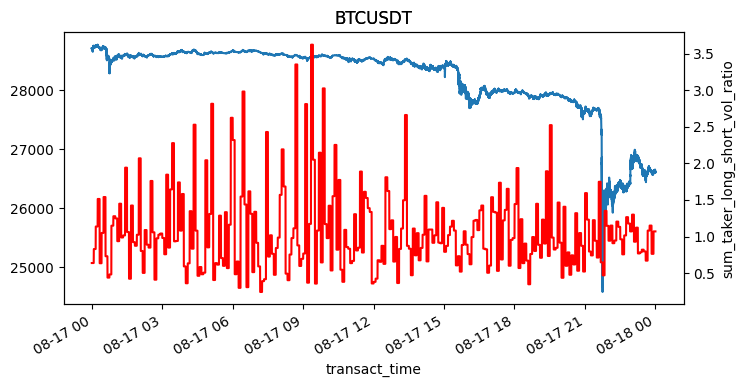

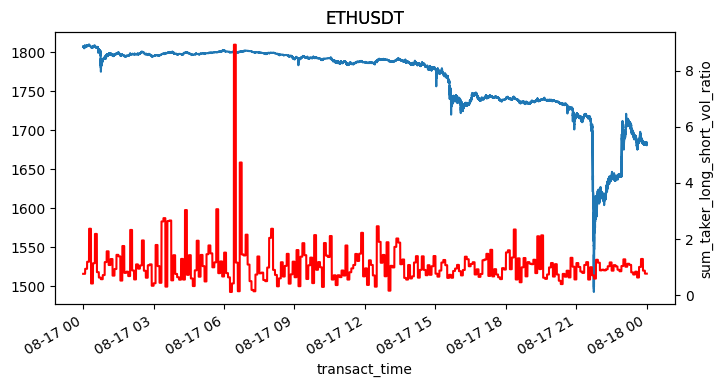

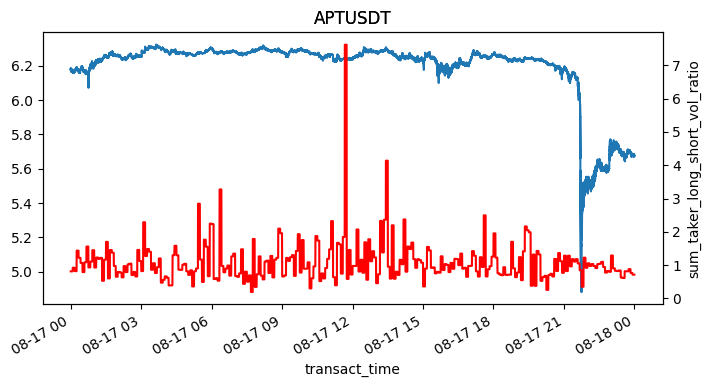

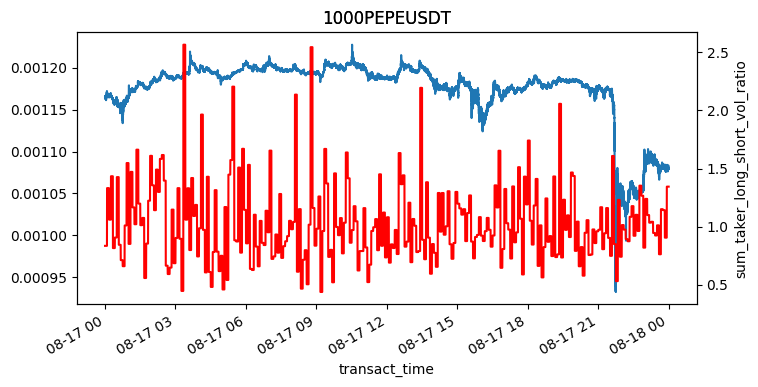

In [43]:
for product in product_list:
    merged = merged_by_product[product]
    ax = merged["price"].plot(figsize=(8, 4), title=product)
    ax2 = ax.twinx()
    ax2.set_ylabel("sum_taker_long_short_vol_ratio")
    # price_df["quote_qty_ratio"].plot(figsize=(8, 4), title=product, ax=ax2, color="green")
    merged["sum_taker_long_short_vol_ratio"].plot(figsize=(8, 4), title=product, ax=ax2, color="red")
    plt.show()

In [91]:
data = helper.get_data("OPUSDT", date_str, columns=['time'])

In [111]:
data['time'] = pd.to_datetime(data['time']).dt.tz_localize(None)

In [110]:
data['time']

70562   2023-07-12 20:56:52.659000+00:00
70563   2023-07-12 20:56:53.751000+00:00
70564   2023-07-12 20:56:54.776000+00:00
70565   2023-07-12 20:56:55.927000+00:00
70566   2023-07-12 20:56:56.968000+00:00
                      ...               
9995    2023-07-14 02:52:25.221000+00:00
9996    2023-07-14 02:52:26.261000+00:00
9997    2023-07-14 02:52:27.268000+00:00
9998    2023-07-14 02:52:28.312000+00:00
9999    2023-07-14 02:52:29.352000+00:00
Name: time, Length: 101627, dtype: datetime64[ns, UTC]

In [116]:
merged2 = agg_trades_by_product['OPUSDT'].reindex(index=data['time'], method='ffill')

In [118]:
merged2.iloc[20000:30000]

,agg_trade_id,price,quantity,first_trade_id,last_trade_id,is_buyer_maker
time,,,,,,
2023-07-13 03:00:00.078,133940081.0,1.2159,1534.6,325471215.0,325471217.0,True
2023-07-13 03:00:01.108,133940083.0,1.2159,107.1,325471225.0,325471226.0,True
2023-07-13 03:00:02.136,133940087.0,1.2157,4739.6,325471233.0,325471238.0,True
2023-07-13 03:00:03.147,133940091.0,1.2156,16.5,325471248.0,325471249.0,False
2023-07-13 03:00:04.163,133940094.0,1.2153,415.6,325471253.0,325471254.0,True
...,...,...,...,...,...,...
2023-07-13 06:02:02.668,133948485.0,1.2187,32.8,325501356.0,325501356.0,False
2023-07-13 06:02:03.673,133948487.0,1.2186,1063.5,325501358.0,325501360.0,True
2023-07-13 06:02:04.681,133948487.0,1.2186,1063.5,325501358.0,325501360.0,True


In [159]:
from research.orderbook_strategies.utils.trades_factors import factor_last_buy_value_ratio_cross_more_positions, factor_doublebuy_value_ratio, factor_large_trade_ratio, factor_last_buy_count_ratio, factor_last_buy_value_ratio
signal_list = [factor_last_buy_value_ratio_cross_more_positions(), factor_doublebuy_value_ratio(), factor_large_trade_ratio(), factor_last_buy_count_ratio(), factor_last_buy_value_ratio()]


create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/OPUSDT/trade.buy_power.more_position.12.1024
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/OPUSDT/trade.buy_power.more_position.12.2048
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/OPUSDT/trade.buy_power.more_position.12.4096
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/OPUSDT/trade.buy_power.more_position.12.8192
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/OPUSDT/trade.buy_power.more_position.12.16384
